In [1]:
import os

import geopandas as gpd
import pandas as pd
import numpy as np
import momepy as mm
import networkx as nx
from mapclassify import greedy

from sqlalchemy import create_engine

import matplotlib.pyplot as plt

user = os.environ.get('DB_USERNAME')
pwd = os.environ.get('DB_PASSWORD')
host = os.environ.get('DB_HOSTNAME')
port = os.environ.get('DB_PORT')

url = f"postgres+psycopg2://{user}:{pwd}@{host}:{port}/geodemo"
engine = create_engine(url)

In [3]:
def pgselect(table, buffer=10000, x=338250, y=392250):
    sql = f'''
    SELECT * FROM {table} 
    WHERE ST_DWithin(geometry, ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer})'''
    return gpd.read_postgis(sql, engine, geom_col='geometry')

In [30]:
encs = pgselect('enclosures', 3000)
roads = pgselect('openroads', 3000)
uprn = pgselect('openuprn', 3000)
localroads = roads.loc[(roads.roadFunction=='Local Road')
                      | (roads.roadFunction=='Restricted Local Access Road')]

<AxesSubplot:>

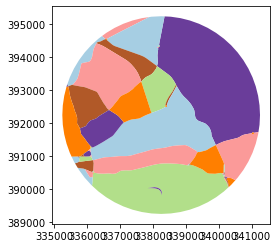

In [5]:
from shapely.geometry import Point

z = Point(338250, 392250)
circle = z.buffer(3000)
c = circle.boundary

# slice enclosures with the circle, and keep only contained part

from shapely.ops import split
from shapely.geometry import MultiPolygon

# def encircle(polygon, circle, b=1):
#     '''Slice polygon with circle and return only contained parts'''
#     return MultiPolygon([p for p in 
#                          list(split(polygon, c)) 
#                          if circle.buffer(b).contains(p)])


def encircle(polygon):
    return MultiPolygon([p for p in list(split(polygon,c)) if circle.buffer(1).contains(p)])

sliced = encs.geometry.apply(lambda x: encircle(x))
esliced = gpd.GeoDataFrame(geometry=sliced)
polygon = encs.geometry[0]
esliced['c'] = greedy(esliced)
esliced.plot('c',cmap='Paired')

<AxesSubplot:>

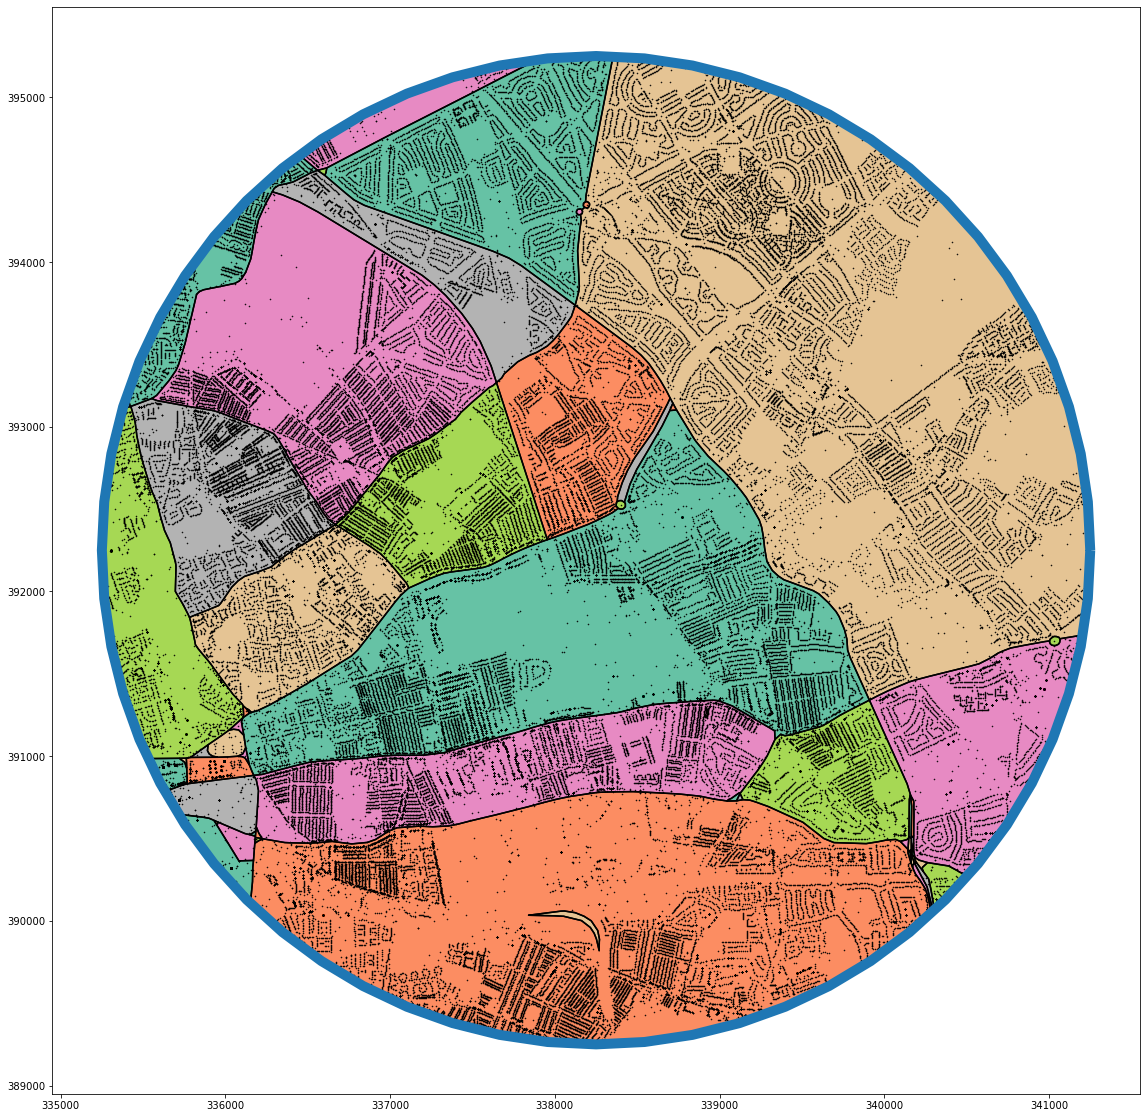

In [28]:

fig, ax = plt.subplots(figsize=(20,20))
esliced.plot('c', ax=ax, cmap='Set2')
esliced.geometry.boundary.plot(ax=ax, color='k')
# localroads.plot(ax=ax, color='w', legend=True, linewidth=2)
gpd.GeoDataFrame(geometry=gpd.GeoSeries(c)).plot(ax=ax, linewidth=10)

uprn.plot(color='k', markersize=0.3, ax=ax)

In [27]:
b_rds = roads.loc[(roads.roadFunction == 'B Road') | (roads.roadFunction == 'Minor Road')]

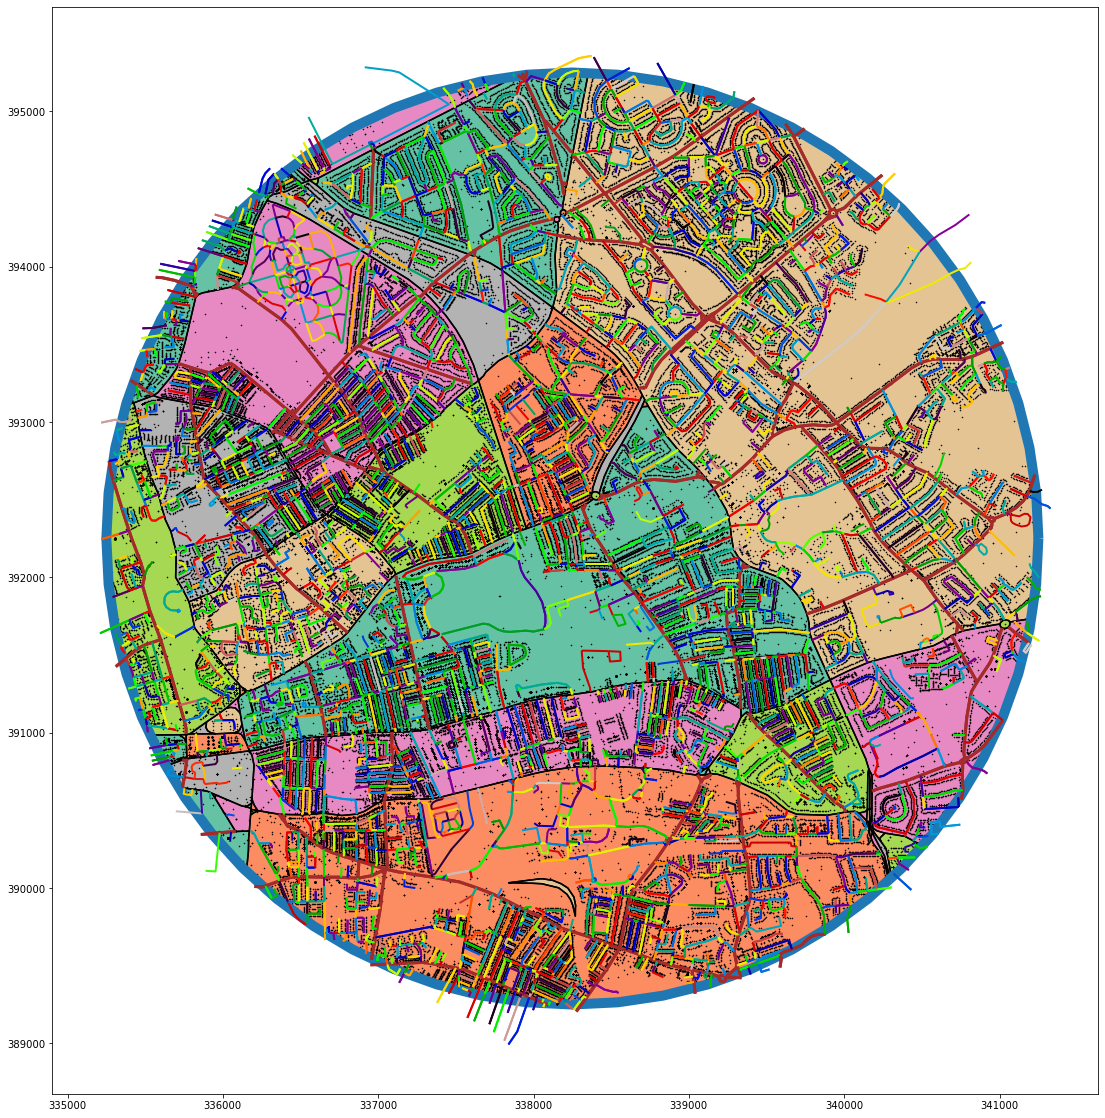

<Figure size 432x288 with 0 Axes>

In [31]:

# fig, ax = plt.subplots(figsize=(20,20))

# uprn.plot(color='k', markersize=0.3, ax=ax)
b_rds.plot(ax=ax, color='brown', linewidth=3)
localroads.plot('id', ax=ax,cmap='nipy_spectral',linewidth=2)
fig

In [22]:
# iterate through roads
for i in range(len(roads[:3])):
    rd = roads.iloc[i]
    for j in range(len(encs)):
        e = encs.iloc[j]
        if e.geometry.buffer(10).contains(rd.geometry):
            roads.iloc[i].enclosure = j 
        
    
# find containing enclosure

/opt/conda/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
